In [49]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
from ladybug.epw import EPW
from pvlib.irradiance import get_total_irradiance
from pvlib.location import Location
from pydantic import BaseModel

path = Path("../data/epws/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2009-2023 copy.epw")
epw = EPW(path)
dbt = np.array(epw.dry_bulb_temperature)
direct_rad = np.array(epw.direct_normal_radiation)
diffuse_rad = np.array(epw.diffuse_horizontal_radiation)
ghi = np.array(epw.global_horizontal_radiation)
lat = epw.location.latitude
lon = epw.location.longitude
epw_tz = epw.location.time_zone
tz = pytz.timezone("US/Eastern")
loc = Location(latitude=lat, longitude=lon, tz=tz)
dt = pd.date_range(start="2024-01-01", end="2024-12-31", freq="H", tz=tz)
pos = loc.get_solarposition(dt)
pos = pos.iloc[:-1]
az = pos.azimuth
zen = pos.zenith

C:\Users\szvsw\AppData\Local\Temp\ipykernel_47280\760594039.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dt = pd.date_range(start="2024-01-01", end="2024-12-31", freq="H", tz=tz)


<Axes: >

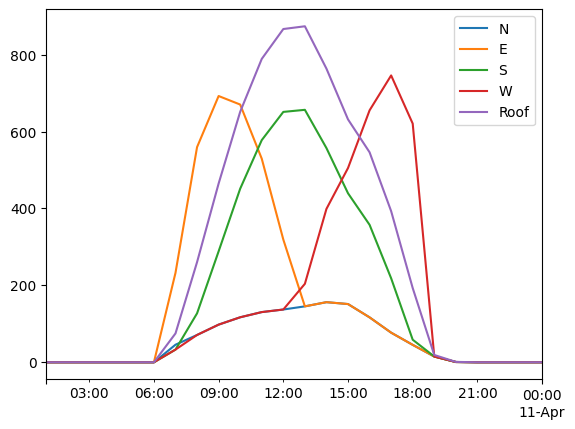

In [50]:
rad_n = get_total_irradiance(
    surface_tilt=90,
    surface_azimuth=0,
    dni=direct_rad,
    ghi=ghi,
    dhi=diffuse_rad,
    solar_azimuth=az,
    solar_zenith=zen,
    albedo=0.2,
).poa_global
rad_e = get_total_irradiance(
    surface_tilt=90,
    surface_azimuth=90,
    dni=direct_rad,
    ghi=ghi,
    dhi=diffuse_rad,
    solar_azimuth=az,
    solar_zenith=zen,
    albedo=0.2,
).poa_global
rad_s = get_total_irradiance(
    surface_tilt=90,
    surface_azimuth=180,
    dni=direct_rad,
    ghi=ghi,
    dhi=diffuse_rad,
    solar_azimuth=az,
    solar_zenith=zen,
    albedo=0.2,
).poa_global
rad_w = get_total_irradiance(
    surface_tilt=90,
    surface_azimuth=270,
    dni=direct_rad,
    ghi=ghi,
    dhi=diffuse_rad,
    solar_azimuth=az,
    solar_zenith=zen,
    albedo=0.2,
).poa_global

rad_roof = get_total_irradiance(
    surface_tilt=0,
    surface_azimuth=0,
    dni=direct_rad,
    ghi=ghi,
    dhi=diffuse_rad,
    solar_azimuth=az,
    solar_zenith=zen,
    albedo=0.2,
).poa_global

rads = pd.DataFrame({
    "N": rad_n,
    "E": rad_e,
    "S": rad_s,
    "W": rad_w,
    "Roof": rad_roof,
})

rads.iloc[100 * 24 : 101 * 24].plot()

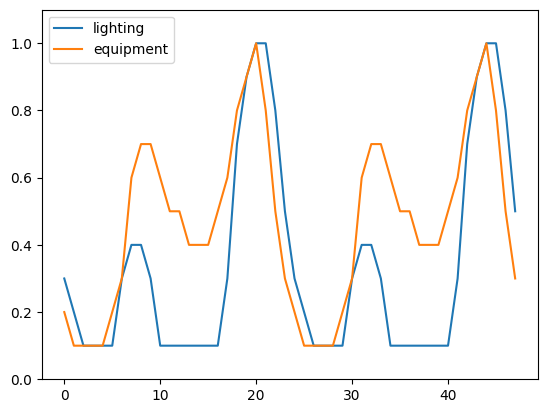

In [51]:
equipment_daily_schedule = [
    0.2,  # 12:00am
    0.1,  # 1:00am
    0.1,  # 2:00am
    0.1,  # 3:00am
    0.1,  # 4:00am
    0.2,  # 5:00am
    0.3,  # 6:00am
    0.6,  # 7:00am
    0.7,  # 8:00am
    0.7,  # 9:00am
    0.6,  # 10:00am
    0.5,  # 11:00am
    0.5,  # 12:00pm
    0.4,  # 1:00pm
    0.4,  # 2:00pm
    0.4,  # 3:00pm
    0.5,  # 4:00pm
    0.6,  # 5:00pm
    0.8,  # 6:00pm
    0.9,  # 7:00pm
    1,  # 8:00pm
    0.8,  # 9:00pm
    0.5,  # 10:00pm
    0.3,  # 11:00pm
] * 365

lighting_daily_schedule = [
    0.3,  # 12:00am
    0.2,  # 1:00am
    0.1,  # 2:00am
    0.1,  # 3:00am
    0.1,  # 4:00am
    0.1,  # 5:00am
    0.3,  # 6:00am
    0.4,  # 7:00am
    0.4,  # 8:00am
    0.3,  # 9:00am
    0.1,  # 10:00am
    0.1,  # 11:00am
    0.1,  # 12:00pm
    0.1,  # 1:00pm
    0.1,  # 2:00pm
    0.1,  # 3:00pm
    0.1,  # 4:00pm
    0.3,  # 5:00pm
    0.7,  # 6:00pm
    0.9,  # 7:00pm
    1,  # 8:00pm
    1,  # 9:00pm
    0.8,  # 10:00pm
    0.5,  # 11:00pm
] * 365
plt.plot(lighting_daily_schedule[:48], label="lighting")
plt.plot(equipment_daily_schedule[:48], label="equipment")
plt.ylim(0, 1.1)
plt.legend()

In [201]:
AIR_DENSITY = 1.225  # kg/m^3
AIR_SPECIFIC_HEAT = 1005  # J/(kg*K)


class SchematicBuilding(BaseModel, arbitrary_types_allowed=True):
    length: float = 10  # m
    width: float = 10  # m
    num_floors: float = 2  # floors
    f2f_height: float = 2.8  # m
    wwr: float = 0.01  # frac

    epd: float = 3.1  # W/m^2
    lpd: float = 2.2  # W/m^2

    equip_schedule: np.ndarray = np.array(equipment_daily_schedule)
    lighting_schedule: np.ndarray = np.array(lighting_daily_schedule)

    hsp_schedule: np.ndarray = np.array([20] * 24 * 365)  # degC
    csp_schedule: np.ndarray = np.array([20] * 24 * 365)  # degC

    # roof_R: float = 1 / 0.54  # m^2*K/W
    roof_R: float = 1 / 0.19  # m^2*K/W
    # roof_R: float = 1 / 0.103  # m^2*K/W

    wall_R: float = 1 / 0.47  # m^2*K/W
    # wall_R: float = 1 / 0.204  # m^2*K/W
    # wall_R: float = 1 / 0.14  # m^2*K/W

    wall_absorptance: float = 0.0  # frac
    roof_absorptance: float = 0.0  # frac
    wall_hext: float = 10  # W/m^2*K
    roof_hext: float = 15  # W/m^2*K

    # window_U: float = 5.894  # W/m^2*K
    # window_U: float = 2.72  # W/m^2*K
    window_U: float = 1.493  # W/m^2*K

    # window_shgc: float = 0.905  # frac
    # window_shgc: float = 0.764  # frac
    window_shgc: float = 0.373  # frac

    # infiltration_rate: float = 0.5  # 1/h
    infiltration_rate: float = 0.2  # 1/h
    # infiltration_rate: float = 0.1  # 1/h

    dbt: np.ndarray = dbt  # degC

    heat_cop: float = 1
    cool_cop: float = 1

    @property
    def footprint_area(self) -> float:
        return self.length * self.width

    @property
    def gfa(self) -> float:
        return self.footprint_area * self.num_floors

    @property
    def total_volume(self) -> float:
        return self.footprint_area * self.f2f_height * self.num_floors

    @property
    def total_facade_area(self) -> float:
        return 2 * (self.length + self.width) * self.f2f_height * self.num_floors

    @property
    def east_facade_area(self) -> float:
        return self.length * self.f2f_height * self.num_floors

    @property
    def west_facade_area(self) -> float:
        return self.length * self.f2f_height * self.num_floors

    @property
    def north_facade_area(self) -> float:
        return self.width * self.f2f_height * self.num_floors

    @property
    def south_facade_area(self) -> float:
        return self.width * self.f2f_height * self.num_floors

    @property
    def east_window_area(self) -> float:
        return self.east_facade_area * self.wwr

    @property
    def west_window_area(self) -> float:
        return self.west_facade_area * self.wwr

    @property
    def north_window_area(self) -> float:
        return self.north_facade_area * self.wwr

    @property
    def south_window_area(self) -> float:
        return self.south_facade_area * self.wwr

    @property
    def east_wall_area(self) -> float:
        return self.east_facade_area - self.east_window_area

    @property
    def west_wall_area(self) -> float:
        return self.west_facade_area - self.west_window_area

    @property
    def north_wall_area(self) -> float:
        return self.north_facade_area - self.north_window_area

    @property
    def south_wall_area(self) -> float:
        return self.south_facade_area - self.south_window_area

    @property
    def total_window_area(self) -> float:
        assert (
            self.total_facade_area
            == self.east_facade_area
            + self.west_facade_area
            + self.north_facade_area
            + self.south_facade_area
        )

        return self.total_facade_area * self.wwr

    @property
    def total_wall_area(self) -> float:
        assert (
            self.total_facade_area
            == self.east_facade_area
            + self.west_facade_area
            + self.north_facade_area
            + self.south_facade_area
        )
        return self.total_facade_area - self.total_window_area

    @property
    def total_roof_area(self) -> float:
        return self.footprint_area

    @property
    def delta_T(self) -> np.ndarray:
        heating_diff = self.dbt - self.hsp_schedule
        cooling_diff = self.dbt - self.csp_schedule
        heating_diff = np.clip(heating_diff, None, 0)
        cooling_diff = np.clip(cooling_diff, 0, None)
        delta_T = heating_diff + cooling_diff
        return delta_T

    @property
    def total_equip_power(self) -> float:
        return self.gfa * self.epd  # W

    @property
    def total_lighting_power(self) -> float:
        return self.gfa * self.lpd  # W

    @property
    def equip_load(self) -> np.ndarray:
        return self.equip_schedule * self.total_equip_power  # W

    @property
    def lighting_load(self) -> np.ndarray:
        return self.lighting_schedule * self.total_lighting_power  # W

    @property
    def infiltration_volflowrate(self) -> float:
        return self.infiltration_rate * self.total_volume / 3600  # m3/s

    @property
    def infiltration_massflowrate(self) -> float:
        return self.infiltration_volflowrate * AIR_DENSITY  # kg/s

    @property
    def infiltration_coefficient(self) -> float:
        return self.infiltration_massflowrate * AIR_SPECIFIC_HEAT  # W/K

    @property
    def east_window_rad_gains(self) -> np.ndarray:
        return self.east_window_area * rads.E.values * self.window_shgc

    @property
    def west_window_rad_gains(self) -> np.ndarray:
        return self.west_window_area * rads.W.values * self.window_shgc

    @property
    def north_window_rad_gains(self) -> np.ndarray:
        return self.north_window_area * rads.N.values * self.window_shgc

    @property
    def south_window_rad_gains(self) -> np.ndarray:
        return self.south_window_area * rads.S.values * self.window_shgc

    @property
    def east_wall_irradiation(self) -> np.ndarray:
        return self.east_wall_area * rads.E.values

    @property
    def west_wall_irradiation(self) -> np.ndarray:
        return self.west_wall_area * rads.W.values

    @property
    def north_wall_irradiation(self) -> np.ndarray:
        return self.north_wall_area * rads.N.values

    @property
    def south_wall_irradiation(self) -> np.ndarray:
        return self.south_wall_area * rads.S.values

    @property
    def total_wall_rad_gains(self) -> np.ndarray:
        return (
            (
                self.east_wall_irradiation
                + self.west_wall_irradiation
                + self.north_wall_irradiation
                + self.south_wall_irradiation
            )
            * (self.wall_U / (self.wall_hext + self.wall_U))
            * self.wall_absorptance
        )

    @property
    def total_roof_rad_gains(self) -> np.ndarray:
        return (
            self.total_roof_area
            * rads.Roof.values
            * self.roof_absorptance
            * (self.roof_U / (self.roof_hext + self.roof_U))
        )

    @property
    def wall_U(self) -> float:
        return 1 / self.wall_R  # W/m^2*K

    @property
    def roof_U(self) -> float:
        return 1 / self.roof_R  # W/m^2*K

    @property
    def wall_UA(self) -> float:
        return self.wall_U * self.total_wall_area  # W/K

    @property
    def roof_UA(self) -> float:
        return self.roof_U * self.total_roof_area  # W/K

    @property
    def window_UA(self) -> float:
        return self.window_U * self.total_window_area  # W/K

    @property
    def total_UA(self) -> float:
        return self.wall_UA + self.roof_UA + self.window_UA  # W/K

    @property
    def conduction_heat_gains(self) -> np.ndarray:
        return self.total_UA * self.delta_T  # W

    @property
    def infiltration_heat_gains(self) -> np.ndarray:
        return self.infiltration_coefficient * self.delta_T  # W

    @property
    def internal_gains(self) -> np.ndarray:
        return self.equip_load + self.lighting_load  # W

    @property
    def total_window_rad_gains(self) -> np.ndarray:
        return (
            self.east_window_rad_gains
            + self.west_window_rad_gains
            + self.north_window_rad_gains
            + self.south_window_rad_gains
        )

    @property
    def total_heat_gains(self) -> np.ndarray:
        return (
            self.total_window_rad_gains
            + self.total_wall_rad_gains
            + self.total_roof_rad_gains
            + self.conduction_heat_gains
            + self.infiltration_heat_gains
            + self.internal_gains
        )  # W

    @property
    def heating_load(self) -> np.ndarray:
        return np.abs(np.clip(self.total_heat_gains, None, 0))

    @property
    def cooling_load(self) -> np.ndarray:
        return np.clip(self.total_heat_gains, 0, None)

    @property
    def heating_eui(self) -> float:
        return float(self.heating_load.sum() / self.gfa / self.heat_cop / 1000)

    @property
    def cooling_eui(self) -> float:
        return float(self.cooling_load.sum() / self.gfa / self.cool_cop / 1000)

    @property
    def equipment_eui(self) -> float:
        return float(self.equip_load.sum() / self.gfa / 1000)

    @property
    def lighting_eui(self) -> float:
        return float(self.lighting_load.sum() / self.gfa / 1000)

In [244]:
import pandas as pd

roof_r_vals = [1 / 0.54, 1 / 0.19, 1 / 0.103]
roof_r_labels = ["UninsulatedRoof", "InsulatedRoof", "HighlyInsulatedRoof"]
wall_r_vals = [1 / 0.47, 1 / 0.204, 1 / 0.14]
wall_r_labels = [
    "SomeInsulationWalls",
    "FullInsulationWallsCavity",
    "FullInsulationWallsCavityExterior",
]
window_vals = [(5.894, 0.905), (2.72, 0.764), (1.493, 0.373)]
window_u_labels = ["SinglePane", "DoublePaneLowE", "TriplePaneLowE"]
weatherization_vals = [0.5, 0.2, 0.1]
weatherization_labels = ["LeakyEnvelope", "SomewhatLeakyEnvelope", "TightEnvelope"]

# used_roof_r_vals = []
# used_wall_r_vals = []
# used_window_u_vals = []
# used_window_shgc_vals = []
# used_weatherization_vals = []
used_roof_labels = []
used_wall_labels = []
used_window_labels = []
used_weatherization_labels = []
heating_euis = []
cooling_euis = []
wwr = 0.12
num_floors = 8
wall_absorptance = 0.7
wall_hext = 10
roof_absorptance = 0.7
roof_hext = 10
lpd = 2.2
epd = 3.1
disable_solar_rad_gains = False
for roof_label, roof_r in zip(roof_r_labels, roof_r_vals, strict=False):
    for wall_label, wall_r in zip(wall_r_labels, wall_r_vals, strict=False):
        for window_label, (window_u, window_shgc) in zip(
            window_u_labels, window_vals, strict=False
        ):
            for weatherization_label, w in zip(
                weatherization_labels, weatherization_vals, strict=False
            ):
                building = SchematicBuilding(
                    roof_R=roof_r,
                    wall_R=wall_r,
                    window_U=window_u,
                    window_shgc=0 if disable_solar_rad_gains else window_shgc,
                    infiltration_rate=w,
                    wwr=wwr,
                    num_floors=num_floors,
                    wall_absorptance=0 if disable_solar_rad_gains else wall_absorptance,
                    roof_absorptance=0 if disable_solar_rad_gains else roof_absorptance,
                    wall_hext=wall_hext,
                    roof_hext=roof_hext,
                    lpd=lpd,
                    epd=epd,
                )
                used_roof_labels.append(roof_label)
                used_wall_labels.append(wall_label)
                used_window_labels.append(window_label)
                used_weatherization_labels.append(weatherization_label)
                heating_euis.append(building.heating_eui / 3.154)
                cooling_euis.append(building.cooling_eui / 3.154)

df = pd.DataFrame({
    "Roof": used_roof_labels,
    "Wall": used_wall_labels,
    "Window": used_window_labels,
    "Weatherization": used_weatherization_labels,
    "Heating": heating_euis,
    "Cooling": cooling_euis,
})

0.7218249321507826

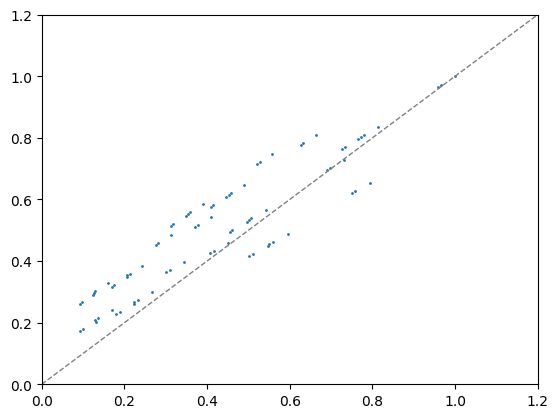

In [245]:
from sklearn.metrics import r2_score

sim_df = pd.read_csv("../sim-out-full-no-people-ventprovider-natural-with-windows.csv")
# sim_df = sim_df[sim_df.Window != "SinglePane"]
(
    sim_df[["Roof", "Wall", "Window", "Weatherization"]]
    == df[["Roof", "Wall", "Window", "Weatherization"]]
).all().all()
df["Heating"] = df["Heating"] / df["Heating"].max()
df["Cooling"] = df["Cooling"] / df["Cooling"].max()
sim_df["Heating"] = sim_df["Heating"] / sim_df["Heating"].max()
sim_df["Cooling"] = sim_df["Cooling"] / sim_df["Cooling"].max()

# plt.scatter(sim_df["Heating"], df["Heating"], s=1)
# plt.plot([0, 20], [0, 20], "--", color="k")
# plt.scatter(sim_df["Wall"], sim_df["Heating"], s=1)
# plt.scatter(sim_df["Wall"], df["Heating"], s=1)
plot_col = "Heating"
all_data = pd.concat([sim_df, df], keys=["sim", "fp"], names=["method"]).reset_index()
# px.line(
#     all_data,
#     facet_row="Roof",
#     facet_col="Wall",
#     color="Window",
#     line_dash="method",
#     x="Weatherization",
#     y=plot_col,
#     width=1000,
#     height=1000,
# ).show()

# px.line(
#     all_data,
#     facet_row="Roof",
#     facet_col="Weatherization",
#     color="Wall",
#     line_dash="method",
#     x="Window",
#     y=plot_col,
#     width=1000,
#     height=1000,
#     range_y=[0,50]
# )
plt.scatter(sim_df[plot_col], df[plot_col], s=1)
plt.xlim(0, max(sim_df[plot_col].max(), df[plot_col].max()) * 1.2)
plt.ylim(0, max(sim_df[plot_col].max(), df[plot_col].max()) * 1.2)
plt.plot(
    [0, max(sim_df[plot_col].max(), df[plot_col].max()) * 1.2],
    [0, max(sim_df[plot_col].max(), df[plot_col].max()) * 1.2],
    "--",
    color="gray",
    lw=1,
)
r2 = r2_score(sim_df[plot_col], df[plot_col])
new_data = (
    all_data.set_index(["method", "Roof", "Wall", "Window", "Weatherization"])[plot_col]
    .unstack(["method"])
    .reset_index()
)
r2

# fig = px.scatter(
#     new_data,
#     x="fp",
#     y="sim",
#     facet_row="Window",
#     facet_col="Weatherization",
#     color="Wall",
#     symbol="Roof",
#     width=1000,
#     height=1000,
#     range_x=[0, 50],
#     range_y=[0, 50],
# )
# # Add identity line to each subplot
# n_rows = new_data["Window"].nunique()
# n_cols = new_data["Weatherization"].nunique()
# for i, row in enumerate(fig.layout.annotations):
#     row_ix = i // n_cols + 1
#     col_ix = i % n_cols + 1
#     fig.add_shape(
#         type="line",
#         x0=0,
#         y0=0,
#         x1=50,
#         y1=50,
#         line=dict(color="gray", width=1, dash="dash"),
#         row=row_ix,
#         col=col_ix,
#     )
# fig.show()

In [179]:
new_data

method,Roof,Wall,Window,Weatherization,fp,sim
0,HighlyInsulatedRoof,FullInsulationWallsCavity,DoublePaneLowE,LeakyEnvelope,15.956947,10.746742
1,HighlyInsulatedRoof,FullInsulationWallsCavity,DoublePaneLowE,SomewhatLeakyEnvelope,10.563596,4.630225
2,HighlyInsulatedRoof,FullInsulationWallsCavity,DoublePaneLowE,TightEnvelope,8.841579,2.911907
3,HighlyInsulatedRoof,FullInsulationWallsCavity,SinglePane,LeakyEnvelope,24.070928,16.144012
4,HighlyInsulatedRoof,FullInsulationWallsCavity,SinglePane,SomewhatLeakyEnvelope,18.413281,9.527707
5,HighlyInsulatedRoof,FullInsulationWallsCavity,SinglePane,TightEnvelope,16.577107,7.485423
6,HighlyInsulatedRoof,FullInsulationWallsCavity,TriplePaneLowE,LeakyEnvelope,13.611218,11.695308
7,HighlyInsulatedRoof,FullInsulationWallsCavity,TriplePaneLowE,SomewhatLeakyEnvelope,7.965343,4.923973
8,HighlyInsulatedRoof,FullInsulationWallsCavity,TriplePaneLowE,TightEnvelope,6.225118,2.941774
9,HighlyInsulatedRoof,FullInsulationWallsCavityExterior,DoublePaneLowE,LeakyEnvelope,14.794825,9.816273


In [153]:
new_data

method,Roof,Wall,Window,Weatherization,fp,sim
0,HighlyInsulatedRoof,FullInsulationWallsCavity,DoublePaneLowE,LeakyEnvelope,15.956947,9.258625
1,HighlyInsulatedRoof,FullInsulationWallsCavity,DoublePaneLowE,SomewhatLeakyEnvelope,10.563596,3.448516
2,HighlyInsulatedRoof,FullInsulationWallsCavity,DoublePaneLowE,TightEnvelope,8.841579,4.912192
3,HighlyInsulatedRoof,FullInsulationWallsCavity,SinglePane,LeakyEnvelope,24.070928,14.891680
4,HighlyInsulatedRoof,FullInsulationWallsCavity,SinglePane,SomewhatLeakyEnvelope,18.413281,8.399094
5,HighlyInsulatedRoof,FullInsulationWallsCavity,SinglePane,TightEnvelope,16.577107,9.985066
6,HighlyInsulatedRoof,FullInsulationWallsCavity,TriplePaneLowE,LeakyEnvelope,13.611218,10.120929
7,HighlyInsulatedRoof,FullInsulationWallsCavity,TriplePaneLowE,SomewhatLeakyEnvelope,7.965343,3.641897
8,HighlyInsulatedRoof,FullInsulationWallsCavity,TriplePaneLowE,TightEnvelope,6.225118,5.042851
9,HighlyInsulatedRoof,FullInsulationWallsCavityExterior,DoublePaneLowE,LeakyEnvelope,14.794825,8.325717


In [200]:
import matplotlib.pyplot as plt
import pandas as pd

building = SchematicBuilding()

summary = (
    pd.Series({
        "heating": building.heating_eui,
        "cooling": building.cooling_eui,
        "equipment": building.equipment_eui,
        "lighting": building.lighting_eui,
    })
    / 3.154
)
summary, summary.sum()

(heating      35.317568
 cooling       1.305034
 equipment     0.000000
 lighting      0.000000
 dtype: float64,
 np.float64(36.62260216893892))

In [201]:
# left = first principles, right = simulation
# sensitivity for weatherization
# leaky -> somewhatleaky
(39 - 32) / 39 * 100, (38 - 26) / 38 * 100
# leaky -> tight
(32 - 26) / 32 * 100, (26 - 14) / 26 * 100

# sensitivity for roof (leaky envelope)
# Uninsulated roof -> Insulated Roof
(39 - 35) / 39 * 100, (38 - 35) / 38 * 100
# Insulated roof -> Highly Insulated Roof
(35 - 34) / 35 * 100, (35 - 34.5) / 35 * 100

# sensitivity for roof (somewhat leaky envelope)
# Uninsulated roof -> Insulated Roof
(32 - 27.7) / 32 * 100, (26 - 23.6) / 26 * 100
# Insulated roof -> Highly Insulated Roof
(27.7 - 26) / 27.7 * 100, (23.6 - 23.1) / 23.6 * 100

# sensitivty for walls (leaky envelope)
# someinsulationwalls -> full/cavity
(35.2 - 26.9) / 35.2 * 100, (35.1 - 30.5) / 35.1 * 100
(26.9 - 24.9) / 26.9 * 100, (30.5 - 29.3) / 30.5 * 100

# sensitivty for walls (somewhat leaky envelope)
# someinsulationwalls -> full/cavity
(27.7 - 19.55) / 27.7 * 100, (23.6 - 19.19) / 23.6 * 100
(19.55 - 17.6) / 19.55 * 100, (19.19 - 18.0) / 19.19 * 100

(9.974424552429664, 6.201146430432523)

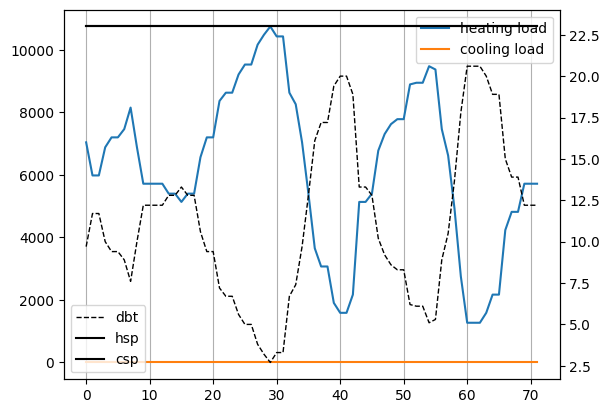

In [202]:
# plt.plot(building.dbt[:72])
# plt.plot(building.delta_T[:72])
# plt.plot(building.dbt[:72])
start_day = 100
n_days = 3
end_day = start_day + n_days
start_hour = start_day * 24
end_hour = end_day * 24

plt.plot(building.heating_load[start_hour:end_hour], label="heating load")
plt.plot(building.cooling_load[start_hour:end_hour], label="cooling load")
# create vertical grid lines along the x-axis
plt.grid(True, axis="x")
plt.legend()
ax2 = plt.twinx()
ax2.plot(building.dbt[start_hour:end_hour], "--", color="k", label="dbt", lw=1)
ax2.plot(building.hsp_schedule[start_hour:end_hour], color="k", label="hsp")
ax2.plot(building.csp_schedule[start_hour:end_hour], color="k", label="csp")
ax2.legend()

# plt.plot(building.total_heat_gains[:72])